In [2]:
from pyrosm import OSM
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

osm = OSM(r"dataset\lahore.osm.pbf")

This cell loads bank and ATM locations from OpenStreetMap, filters and classifies them into MCB vs rivals, and visualizes them using Folium on a map of Lahore.

In [3]:
# Load bank and ATM locations
pois = osm.get_pois(custom_filter={"amenity": ["bank", "atm"]})
pois = pois[pois["name"].notna()]

# Classify MCB and rivals
def is_mcb(name):
    name = str(name).lower()
    return "mcb" in name or "ایم سی بی" in name

pois["is_mcb"] = pois["name"].apply(is_mcb)
mcb_pois = pois[pois["is_mcb"]]
rival_pois = pois[~pois["is_mcb"]]

# Convert CRS for mapping
mcb_pois = mcb_pois.to_crs(epsg=4326)
rival_pois = rival_pois.to_crs(epsg=4326)

# Create map centered on Lahore
center = [31.5204, 74.3587]
m = folium.Map(location=center, zoom_start=12)

# Add marker clusters
mcb_cluster = MarkerCluster(name="MCB Branches/ATMs").add_to(m)
rival_cluster = MarkerCluster(name="Rival Banks/ATMs").add_to(m)

def get_coordinates(geometry):
    if geometry.geom_type == 'Point':
        return (geometry.y, geometry.x)
    elif geometry.geom_type == 'Polygon':
        centroid = geometry.centroid
        return (centroid.y, centroid.x)
    return (geometry.y, geometry.x)

# Add MCB and rival markers
for _, row in mcb_pois.iterrows():
    folium.Marker(
        location=get_coordinates(row.geometry),
        popup=row["name"],
        icon=folium.Icon(color="green", icon="bank", prefix="fa")
    ).add_to(mcb_cluster)

for _, row in rival_pois.iterrows():
    folium.Marker(
        location=get_coordinates(row.geometry),
        popup=row["name"],
        icon=folium.Icon(color="red", icon="bank", prefix="fa")
    ).add_to(rival_cluster)

folium.LayerControl().add_to(m)
m


# Rival Bank Density Heatmap with MCB Overlay
This cell creates a heatmap showing the density of rival bank/ATM locations, overlaid with MCB branches/ATMs as green dots on a dark-themed map of Lahore.

In [4]:
from folium.plugins import HeatMap
from shapely.geometry import Point

# Create dark-themed map
heatmap_map = folium.Map(location=center, zoom_start=12, tiles="CartoDB dark_matter")

# Heatmap for rival banks/ATMs (only Point geometries)
heat_data = [
    [geom.y, geom.x]
    for geom in rival_pois.geometry
    if isinstance(geom, Point)
]
HeatMap(
    heat_data,
    radius=10,
    blur=15,
    gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
).add_to(heatmap_map)

# Overlay MCB locations
for _, row in mcb_pois.iterrows():
    geom = row.geometry
    if isinstance(geom, Point):
        folium.CircleMarker(
            location=[geom.y, geom.x],
            radius=5,
            color="green",
            fill=True,
            fill_opacity=0.7,
            popup=row["name"]
        ).add_to(heatmap_map)

heatmap_map


# KDE Classification of MCB and Rival Bank Densities
This cell performs kernel density estimation (KDE) for MCB and rival bank/ATM locations, classifies the density into 3 categories using Jenks Natural Breaks, and visualizes the results as side-by-side choropleth maps

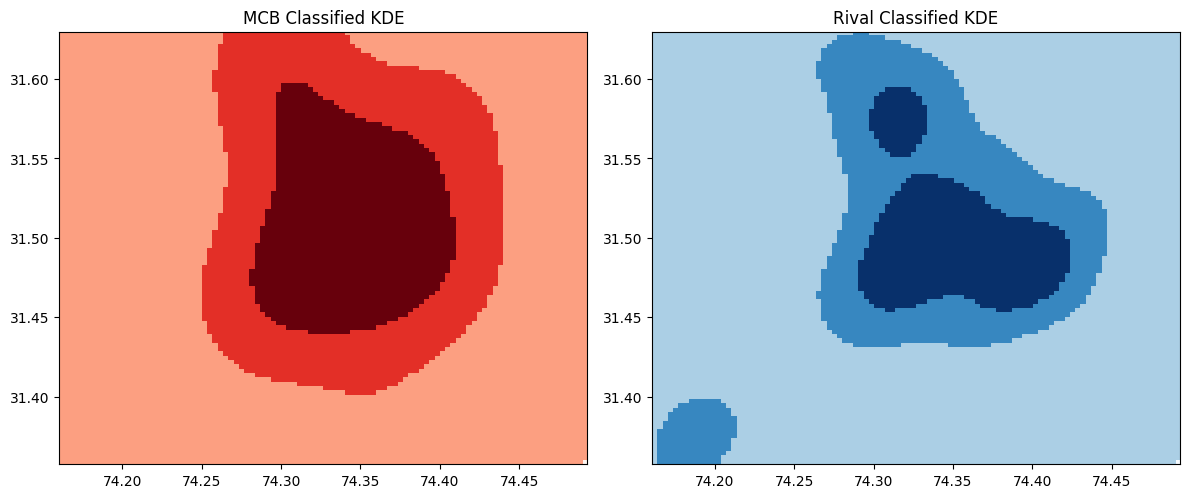

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from jenkspy import JenksNaturalBreaks

# Extract coordinates from GeoDataFrames
def extract_coords(gdf):
    return np.array([
        geom.coords[0] if geom.geom_type == 'Point' else geom.centroid.coords[0]
        for geom in gdf.geometry
    ])

mcb_coords = extract_coords(mcb_pois)
rival_coords = extract_coords(rival_pois)

# Create grid over bounding box
minx, miny, maxx, maxy = pois.total_bounds
x_grid = np.linspace(minx, maxx, 100)
y_grid = np.linspace(miny, maxy, 100)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_coords = np.vstack([xx.ravel(), yy.ravel()])

# Perform KDE
density_mcb = gaussian_kde(mcb_coords.T)(grid_coords).reshape(xx.shape)
density_rival = gaussian_kde(rival_coords.T)(grid_coords).reshape(xx.shape)

# Classify KDE with Jenks
def classify_kde(density, n_classes=3):
    jnb = JenksNaturalBreaks(n_classes=n_classes)
    jnb.fit(density.ravel())
    return np.digitize(density, jnb.breaks_, right=True)

mcb_classified = classify_kde(density_mcb)
rival_classified = classify_kde(density_rival)

# Plot choropleth maps
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(mcb_classified, origin='lower', extent=[minx, maxx, miny, maxy], cmap='Reds')
axs[0].set_title("MCB Classified KDE")
axs[0].axis('on')

axs[1].imshow(rival_classified, origin='lower', extent=[minx, maxx, miny, maxy], cmap='Blues')
axs[1].set_title("Rival Classified KDE")
axs[1].axis('on')

plt.tight_layout()
plt.show()


# 🗺️ KDE Classification on Grid Points with Choropleth Maps
This cell creates a spatial grid from the KDE surface, assigns density values for both MCB and rival banks, classifies them into Low/Medium/High using Jenks Natural Breaks, and plots categorized choropleths.

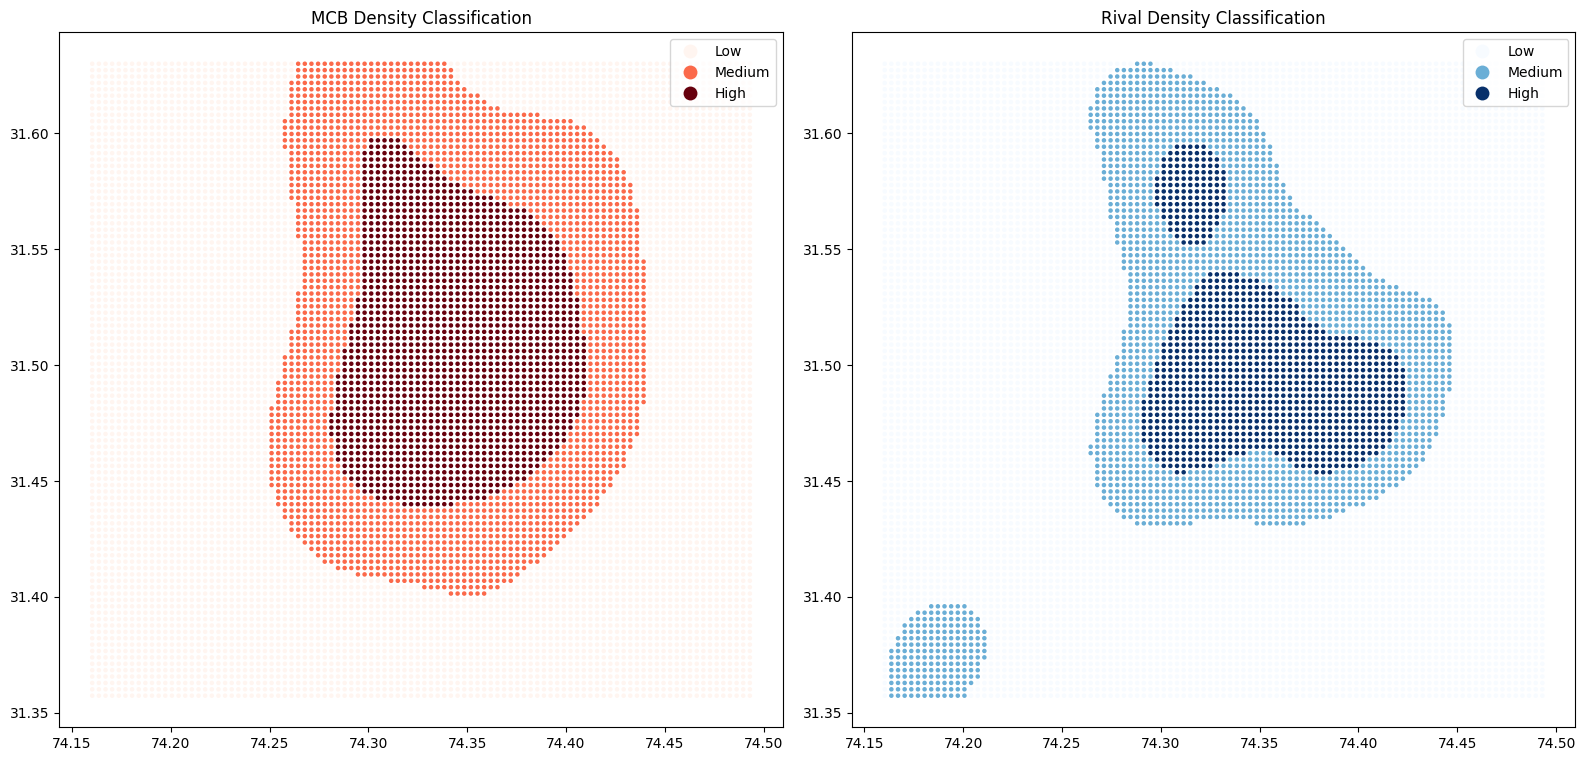

In [6]:
import pandas as pd

# Generate GeoDataFrame of grid points
grid_points = [Point(x, y) for x, y in zip(xx.ravel(), yy.ravel())]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=pois.crs)

# Assign KDE density values to grid using already computed arrays
grid_gdf['mcb_density'] = density_mcb.ravel()
grid_gdf['rival_density'] = density_rival.ravel()

# Classify densities using Jenks Natural Breaks
def classify_from_breaks(values, breaks):
    return pd.cut(values, bins=breaks, labels=['Low', 'Medium', 'High'], include_lowest=True)

mcb_jenks = JenksNaturalBreaks(n_classes=3)
mcb_jenks.fit(grid_gdf['mcb_density'])
rival_jenks = JenksNaturalBreaks(n_classes=3)
rival_jenks.fit(grid_gdf['rival_density'])

grid_gdf['mcb_class'] = classify_from_breaks(grid_gdf['mcb_density'], mcb_jenks.breaks_)
grid_gdf['rival_class'] = classify_from_breaks(grid_gdf['rival_density'], rival_jenks.breaks_)

# Plot MCB and Rival KDE classification
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

grid_gdf.plot(column='mcb_class', categorical=True, legend=True, markersize=5, ax=axes[0], cmap='Reds')
axes[0].set_title("MCB Density Classification")
axes[0].axis('on')

grid_gdf.plot(column='rival_class', categorical=True, legend=True, markersize=5, ax=axes[1], cmap='Blues')
axes[1].set_title("Rival Density Classification")
axes[1].axis('on')

plt.tight_layout()
plt.show()


# 🧭 Final Classification: Detect Bank Opportunities and Visualize with OSM Basemap
This cell identifies potential MCB branch opportunities based on KDE classifications, reprojects OSM layers to match the analysis CRS, and visualizes the opportunity zones on a map with roads and water features.

c:\Users\Abdullah\Desktop\Spacial\mcb-estimation\.venv\Lib\site-packages\pyrosm\networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


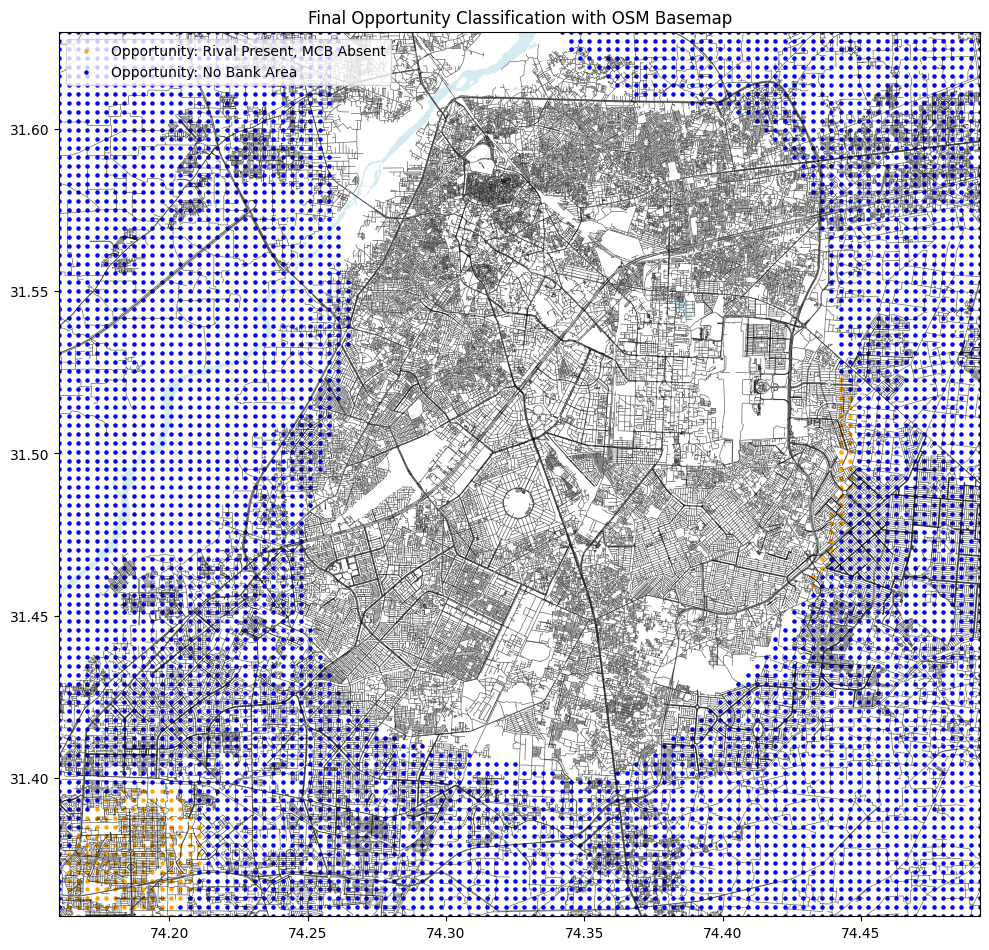

In [7]:
# Combine MCB & Rival Classifications into Final Labels
grid_gdf['id'] = grid_gdf.index + 1  # Assign unique ID

def classify_area(row):
    if row['mcb_class'] == 'Low' and row['rival_class'] in ['Medium', 'High']:
        return 'Opportunity: Rival Present, MCB Absent'
    elif row['mcb_class'] == 'Low' and row['rival_class'] == 'Low':
        return 'Opportunity: No Bank Area'
    else:
        return 'Other'

grid_gdf['final_class'] = grid_gdf.apply(classify_area, axis=1)

# Filter out non-opportunity areas
filtered = grid_gdf[grid_gdf['final_class'] != 'Other']

# Define color mapping
color_map = {
    'Opportunity: Rival Present, MCB Absent': 'orange',
    'Opportunity: No Bank Area': 'blue'
}

# Step 12: Load OSM basemap layers
roads = osm.get_network(network_type="driving")
water = osm.get_data_by_custom_criteria(custom_filter={"natural": ["water"]}, filter_type="keep")

# Reproject OSM layers to match KDE grid CRS
if roads is not None:
    roads = roads.to_crs(filtered.crs)
if water is not None:
    water = water.to_crs(filtered.crs)

# Step 13: Plot final opportunity map
fig, ax = plt.subplots(figsize=(10, 10))


if water is not None and not water.empty:
    water.plot(ax=ax, color='lightblue', alpha=0.5)
if roads is not None and not roads.empty:
    roads.plot(ax=ax, color='black', linewidth=0.5, alpha=0.6)

# Plot KDE-classified opportunities
for label, color in color_map.items():
    filtered.loc[filtered['final_class'] == label].plot(ax=ax, color=color, markersize=5, label=label)

# Set extent and labels
ax.set_xlim(filtered.total_bounds[[0, 2]])
ax.set_ylim(filtered.total_bounds[[1, 3]])
ax.set_title("Final Opportunity Classification with OSM Basemap")
ax.legend(loc='upper left')
ax.axis('on')

plt.tight_layout()
plt.show()


# Highway Proximity Score Mapping with Roads Overlay
This maps how close candidate locations are to major highways, highlighting better-connected areas for MCB branch potential.

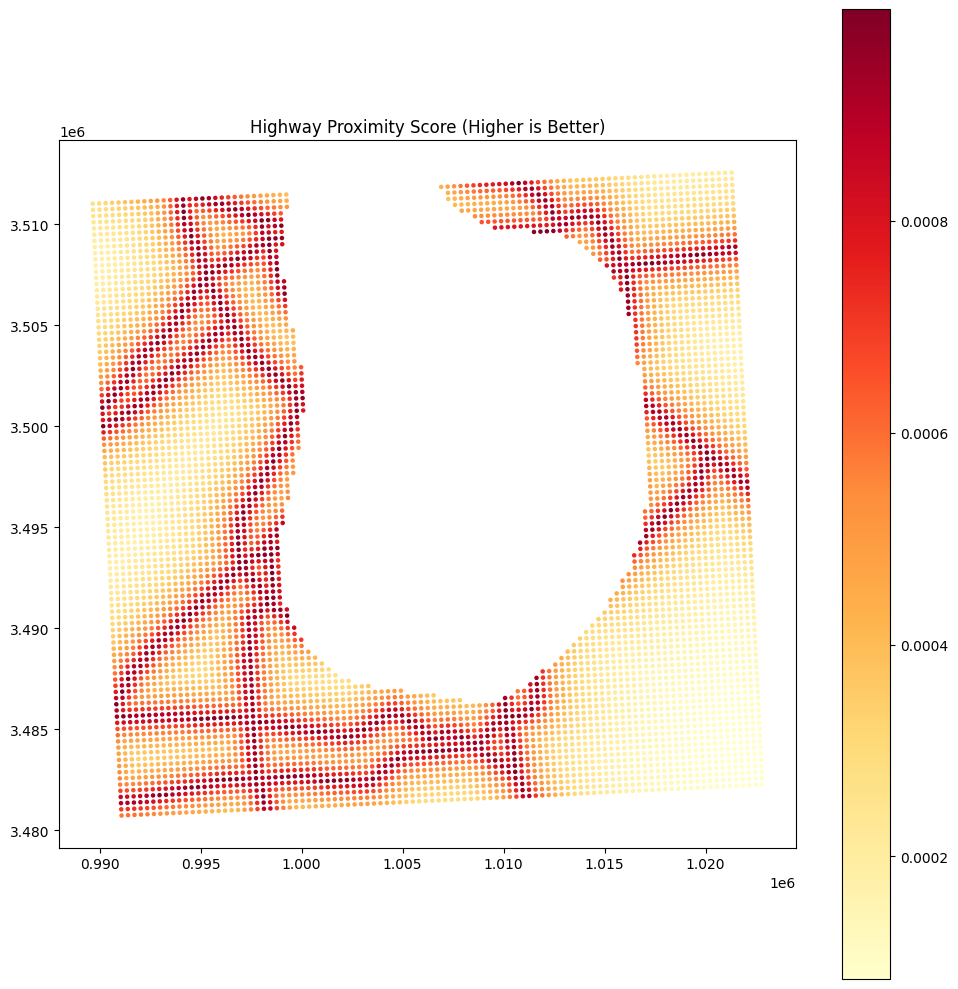

In [8]:
projected_crs = 'EPSG:32642'

# Define major highways from the roads GeoDataFrame
major_highways = roads[roads['highway'].isin(['motorway', 'trunk', 'primary'])]

filtered_proj = filtered.to_crs(projected_crs)
highways_proj = major_highways.to_crs(projected_crs)

filtered_proj['distance_to_highway'] = filtered_proj.geometry.apply(
    lambda geom: highways_proj.distance(geom).min()
)
filtered_proj['highway_proximity_score'] = 1 / (filtered_proj['distance_to_highway'] + 1000)

# roads_proj = roads.to_crs(projected_crs)  # Not needed if not plotting

fig, ax = plt.subplots(figsize=(10, 10))

# Removed roads_proj plot
# roads_proj.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.6)

filtered_proj.plot(
    column='highway_proximity_score',
    cmap='YlOrRd',
    legend=True,
    ax=ax,
    markersize=5
)

ax.set_title("Highway Proximity Score (Higher is Better)")
ax.axis('on')
plt.tight_layout()
plt.show()


# Wealth Indicator Density Map

c:\Users\Abdullah\Desktop\Spacial\mcb-estimation\.venv\Lib\site-packages\mapclassify\classifiers.py:1760: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


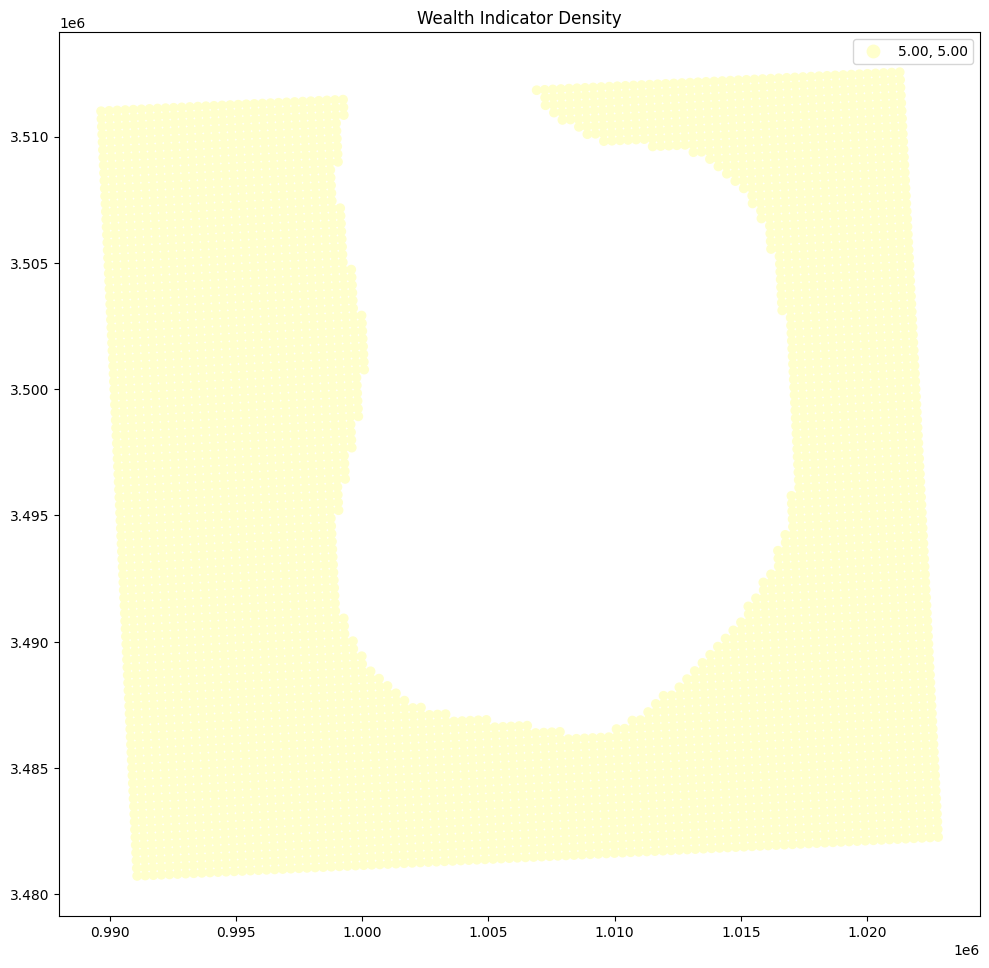

In [9]:
# Ensure filtered_utm is defined by projecting filtered to projected_crs
filtered_utm = filtered.to_crs(projected_crs)

# Ensure 'grid_id' exists in filtered_utm
if 'grid_id' not in filtered_utm.columns:
    filtered_utm['grid_id'] = filtered_utm.index

wealth_indicators = osm.get_pois(custom_filter={
    "amenity": ["restaurant", "cafe", "fast_food", "bar", "pub"],
    "shop": ["mall", "supermarket", "department_store"]
})
wealth_indicators = wealth_indicators[wealth_indicators.geometry.notna()]
wealth_utm = wealth_indicators.to_crs(projected_crs)

wealth_sjoin = gpd.sjoin(wealth_utm, filtered_utm, how='inner', predicate='within')
wealth_density = wealth_sjoin.groupby('grid_id').size()
wealth_density+=3
filtered_utm['wealth_density'] = filtered_utm['grid_id'].map(wealth_density).fillna(5)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
filtered_utm.plot(
    column='wealth_density',
    cmap='YlOrRd',
    scheme='quantiles',  # Add this for visual gradient
    k=5,
    legend=True,
    ax=ax
)
ax.set_title("Wealth Indicator Density")
ax.axis('on')
plt.tight_layout()
plt.show()


# Population Density (Building Count)

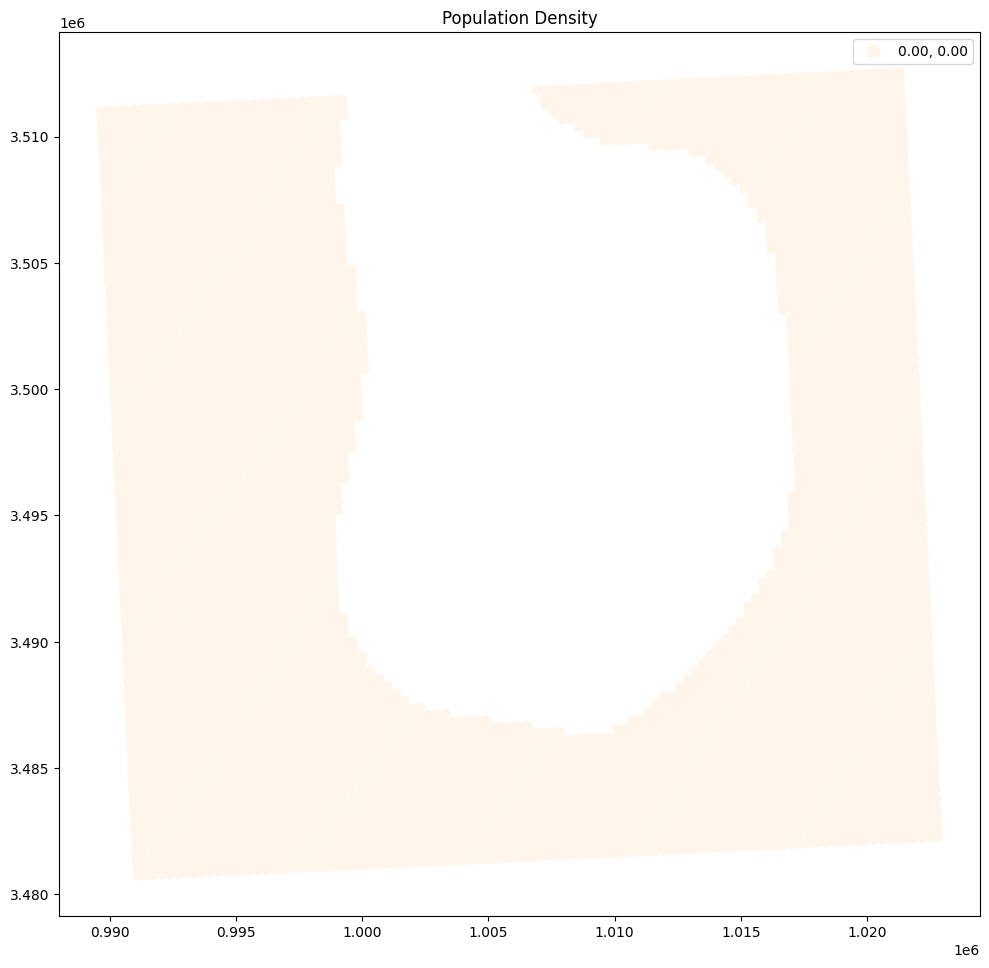

In [10]:
buildings = osm.get_buildings()
buildings = buildings[buildings.geometry.notna()]
buildings_utm = buildings.to_crs(projected_crs)

if 'grid_id' not in filtered_utm.columns:
    filtered_utm['grid_id'] = filtered_utm.index

population_sjoin = gpd.sjoin(buildings_utm, filtered_utm, how='inner', predicate='within')
population_density = population_sjoin.groupby('grid_id').size()
filtered_utm['population_density'] = filtered_utm['grid_id'].map(population_density).fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
filtered_utm.plot(
    column='population_density',
    cmap='Oranges',
    scheme='quantiles',
    k=min(5, filtered_utm['population_density'].nunique()) or 1,
    legend=True,
    ax=ax
)
ax.set_title("Population Density")
ax.axis('on')
plt.tight_layout()
plt.show()


# Suitability Score (Normalized Aggregation)

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Ensure 'distance_to_highway' exists in filtered_utm by copying from filtered_proj
if 'distance_to_highway' not in filtered_utm.columns and 'distance_to_highway' in filtered_proj.columns:
    filtered_utm['distance_to_highway'] = filtered_proj['distance_to_highway'].values

scored = filtered_utm.copy()
scored['highway_score'] = 1 / (scored['distance_to_highway'] + 1e-6)

scored['population_density'] = scored['population_density'].fillna(0)
# If 'transport_density' does not exist, create it as zeros
if 'transport_density' not in scored.columns:
    scored['transport_density'] = 0
scored['transport_density'] = scored['transport_density'].fillna(0)
scored['wealth_density'] = scored['wealth_density'].fillna(0)

scaler = MinMaxScaler()
normalized = scaler.fit_transform(scored[['highway_score', 'population_density', 'transport_density', 'wealth_density']])

scored[['highway_norm', 'population_norm', 'transport_norm', 'wealth_norm']] = normalized
scored['suitability_score'] = (
    scored['highway_norm'] +
    scored['population_norm'] +
    scored['transport_norm'] +
    scored['wealth_norm']
) / 3


# Visualizing Top 3 Optimal MCB Branch Locations (Per Opportunity Class)
This section selects the top 3 most suitable and geographically dispersed locations for each of the two opportunity categories:

- No Bank Area

- Rival Present, MCB Absent

It visualizes them on a map with a basemap background for spatial context.


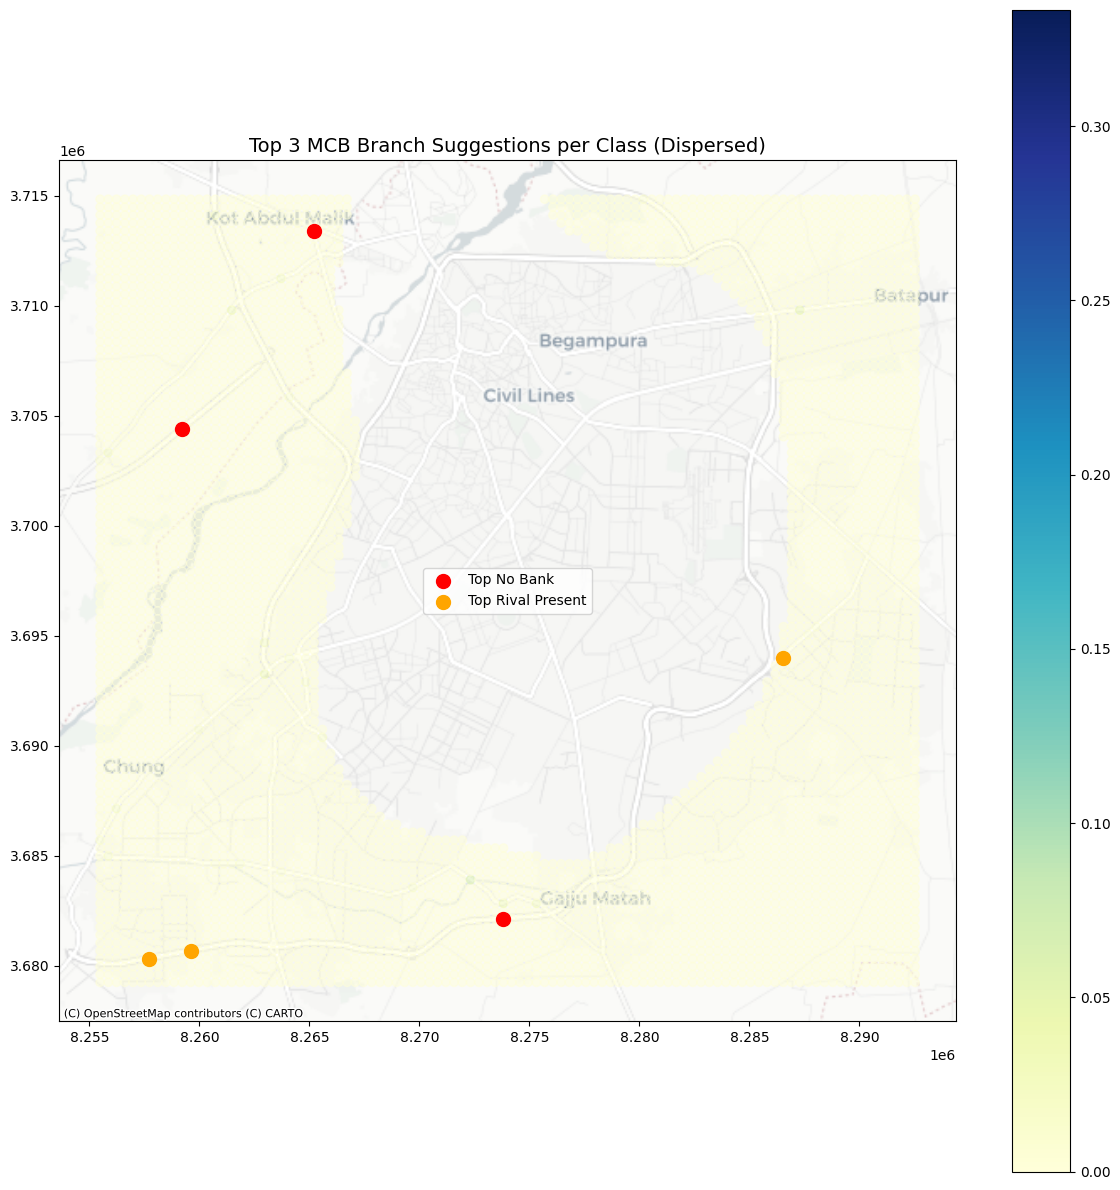

In [12]:
import contextily as ctx


scored_web = scored.to_crs(epsg=3857)


def select_top3_dispersed(gdf_class):
    selected = []
    buffer_dist = 1000  # Minimum distance (in meters) between selected points

    # Sort by score and pick spatially distinct top points
    for _, row in gdf_class.sort_values('suitability_score', ascending=False).iterrows():
        geom = row.geometry
        if not any(geom.distance(sel.geometry) < buffer_dist for sel in selected):
            selected.append(row)
        if len(selected) == 3:
            break
    return gpd.GeoDataFrame(selected, crs=gdf_class.crs)

# Apply selection to each opportunity class
top_no_bank = select_top3_dispersed(scored_web[scored_web['final_class'] == 'Opportunity: No Bank Area']).reset_index(drop=True)
top_rival = select_top3_dispersed(scored_web[scored_web['final_class'] == 'Opportunity: Rival Present, MCB Absent']).reset_index(drop=True)

# Assign rank to each point
top_no_bank['rank'] = top_no_bank.index + 1
top_rival['rank'] = top_rival.index + 1

# Write ranked points with coordinates and scores to text file
with open("top_mcb_locations.txt", "w") as f:
    f.write("Top 3 Locations - Opportunity: No Bank Area\n")
    for _, row in top_no_bank.iterrows():
        f.write(f"Rank {row['rank']}: {row.geometry.x:.2f}, {row.geometry.y:.2f} | Score: {row['suitability_score']:.4f}\n")

    f.write("\nTop 3 Locations - Opportunity: Rival Present, MCB Absent\n")
    for _, row in top_rival.iterrows():
        f.write(f"Rank {row['rank']}: {row.geometry.x:.2f}, {row.geometry.y:.2f} | Score: {row['suitability_score']:.4f}\n")

# Plot suitability map with top points over basemap
fig, ax = plt.subplots(figsize=(12, 12))
scored_web.plot(ax=ax, column='suitability_score', cmap='YlGnBu', alpha=0.5, legend=True)
top_no_bank.plot(ax=ax, color='red', markersize=100, label='Top No Bank')
top_rival.plot(ax=ax, color='orange', markersize=100, label='Top Rival Present')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Top 3 MCB Branch Suggestions per Class (Dispersed)', fontsize=14)
ax.axis('on')
ax.legend()
plt.tight_layout()
plt.show()
